In [4]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta # technical indicators
import datetime as dt
import xgboost as xgb

# Part 1 - Using in-class models
import sklearn.datasets as datasets
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression #need this for linear regression
from sklearn.linear_model import LogisticRegression # need this for logistic regression
from sklearn.ensemble import RandomForestRegressor # need this for random forest regression
from sklearn.model_selection import train_test_split # need this for testing
from sklearn.metrics import mean_squared_error # need this for test evalution
from sklearn.svm import SVR # need this for SVR (regression)
from sklearn import linear_model
from sklearn.linear_model import Ridge

# Part 2 - GAPs as predictors
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import linregress

# Part 3 - Using LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# import to ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Download Stock Data from Yahoo Finance
 
ticker = yf.Ticker('AMZN')
start = dt.datetime(2015, 1, 3).strftime('%Y-%m-%d')
dt.datetime.today().strftime('%Y-%m-%d')
end = dt.datetime(2025,4, 11).strftime('%Y-%m-%d')  # should pick at least 400 trading days or about 2 years or more
data = ticker.history(start=start, end=end)
data.to_csv('Meta_Data.csv')
data = pd.read_csv('Meta_Data.csv')

# Make date a column
data.Date = pd.to_datetime(data.Date, utc = True)

# Drop divs and stock splits
data = data.iloc[:, 0:6]

# Add technical indicators
data['RSI']=ta.rsi(data.Close, length = 14)  # 14 is usual days for RSI calc, momentum
data['CCI']=ta.cci(data.High, data.Low, data.Close, window = 20, constant =0.015, fillna = False) # defaults for CCI, momentum
data['ATR']=ta.atr(data.High, data.Low, data.Close, length = 14)  # 14 is usual days for ATR calc, volatility
data['EMA10'] = ta.ema(data.Close, length = 10) # short term value, trend
data['EMA50'] = ta.ema(data.Close, length = 50)  # used for 50/200 crossover, trend
data['EMA200'] = ta.ema(data.Close, length = 200)  # used for 50/200 crossover, trend
data['CCI']=data['CCI'].astype(float) # re-classify from object type

# add gaps to data
data['Gap']=(data['Open']-data['Close'].shift(1))
data['Gap_Percent']=(data['Open']/data['Close'].shift(1))-1
data['Intraday']=data['Close']-data['Open']
data['Intraday-Percent']=(data['Close']/data['Open'])-1

# add binary 0-1 (0 = down and 1 = up) for classifier ml algos
data['Up-Down'] = np.where(data['Close'].shift(1) > data['Close'], 0, 1)

# drop first 201 rows since using 200 EMA or GAP based on previous day where NaN values ex
data = data.iloc[201:] 

data.info()  # data info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2382 entries, 201 to 2582
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   Date              2382 non-null   datetime64[ns, UTC]
 1   Open              2382 non-null   float64            
 2   High              2382 non-null   float64            
 3   Low               2382 non-null   float64            
 4   Close             2382 non-null   float64            
 5   Volume            2382 non-null   int64              
 6   RSI               2382 non-null   float64            
 7   CCI               2382 non-null   float64            
 8   ATR               2382 non-null   float64            
 9   EMA10             2382 non-null   float64            
 10  EMA50             2382 non-null   float64            
 11  EMA200            2382 non-null   float64            
 12  Gap               2382 non-null   float64            
 13  G

In [6]:
# 3 Parts
# PART 1: in class ML algos (Random Forest, Linear Regression, Logistics Regression, XGB, SVR)

# regression, just keep open, high, low, close, regression, EMAx's, RSI, CCI

data_ml_linear_models = data.iloc[:, 1:12]
X = data_ml_linear_models[:]


# target variable is next day price
y = data_ml_linear_models['Close'].shift(-1)
X = X[:-1]
y = y[:-1]

# this is wrong for sequential data:
#       X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# split data  -- sequential data must be split by index
train_index = int(0.7 * len(X))
X_train, X_test = X[:train_index], X[train_index:]
y_train, y_test = y[:train_index], y[train_index:]

# classifiers (Logistics regression, also keep binary 1-0 up or down day)

data_ml_classifier_models = data.iloc[:, [1,2,3,4,5,6,7,8,9,10,11,16]]
Xc = data_ml_classifier_models.iloc[:, :11]

# target variable is next day price
yc = data_ml_classifier_models['Up-Down']
Xc = Xc[:-1]
yc = yc[:-1]

# split data
X_trainc, X_testc = Xc[:train_index], Xc[train_index:]
y_trainc, y_testc = yc[:train_index], yc[train_index:]


In [128]:
# PART 1
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3640 entries, 201 to 3840
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3640 non-null   float64
 1   High    3640 non-null   float64
 2   Low     3640 non-null   float64
 3   Close   3640 non-null   float64
 4   Volume  3640 non-null   int64  
 5   RSI     3640 non-null   float64
 6   CCI     3640 non-null   float64
 7   ATR     3640 non-null   float64
 8   EMA10   3640 non-null   float64
 9   EMA50   3640 non-null   float64
 10  EMA200  3640 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 312.9 KB


In [129]:
# PART 1
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 3640 entries, 201 to 3840
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
3640 non-null   float64
dtypes: float64(1)
memory usage: 28.6 KB


In [130]:
# PART 1
Xc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3640 entries, 201 to 3840
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3640 non-null   float64
 1   High    3640 non-null   float64
 2   Low     3640 non-null   float64
 3   Close   3640 non-null   float64
 4   Volume  3640 non-null   int64  
 5   RSI     3640 non-null   float64
 6   CCI     3640 non-null   float64
 7   ATR     3640 non-null   float64
 8   EMA10   3640 non-null   float64
 9   EMA50   3640 non-null   float64
 10  EMA200  3640 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 312.9 KB


In [131]:
# PART 1
yc.info()

<class 'pandas.core.series.Series'>
RangeIndex: 3640 entries, 201 to 3840
Series name: Up-Down
Non-Null Count  Dtype
--------------  -----
3640 non-null   int32
dtypes: int32(1)
memory usage: 14.3 KB


In [5]:
# PART 1
# SVR Regression (poly)
# Scale the data first to handle large values
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Convert Series to numpy array before reshaping
# Fit and transform the training data
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# Transform the test data
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

model_svrr = SVR(kernel = "poly", C=100, gamma="auto", degree = 3, epsilon = 0.1, coef0=1)
model_svrr.fit(X_train_scaled, y_train_scaled)
predictions_scaled = model_svrr.predict(X_test_scaled)
predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1))
mse = mean_squared_error(y_test_scaled, predictions)
print("Model: ", model_svrr)
print ("MSE: ", mse, '\n')
print("Train Score: ", model_svrr.score(X_train_scaled, y_train_scaled))
print("Test Score: ", model_svrr.score(X_test_scaled, y_test_scaled))

Model:  SVR(C=100, coef0=1, gamma='auto', kernel='poly')
MSE:  23470.37013981578 

Train Score:  0.9971782532614596
Test Score:  0.9717187314194633


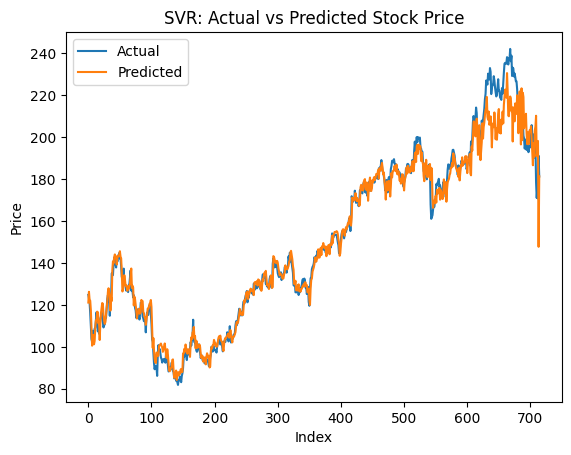

In [6]:
plt.plot(y_test.values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.title("SVR: Actual vs Predicted Stock Price")
plt.xlabel("Index")
plt.ylabel("Price")
plt.show()

In [22]:
# PART 1
# Linear Regression
model_linreg = LinearRegression()
model_linreg.fit(X_train, y_train)
predictions = model_linreg.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print ("Intercept: ", model_linreg.intercept_, '\n', "Coefficents: ", model_linreg.coef_, '\n', "MSE: ", mse, '\n')
print ("Train Score: ", model_linreg.score(X_train, y_train))
print ("Test Score: ", model_linreg.score(X_test, y_test))

Intercept:  0.638312439370651 
 Coefficents:  [-4.99150907e-01  3.83564436e-01  4.91295145e-01  5.61624774e-01
 -1.26436659e-10 -8.09235537e-03  1.41879821e-03  5.22473649e-02
  5.60907703e-02  1.82811542e-02 -1.37035018e-02] 
 MSE:  11.016102208142554 

Train Score:  0.9980429611656166
Test Score:  0.9934901350223921


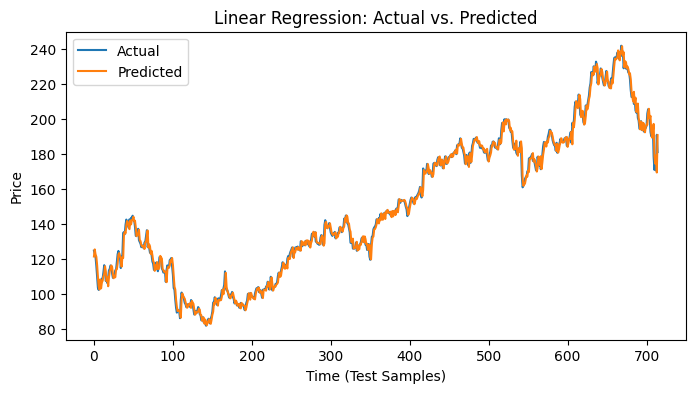

In [8]:
import matplotlib.pyplot as plt

# Suppose X_test.index is a datetime index or just sequential if not
plt.figure(figsize=(8, 4))
plt.plot(y_test.values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel("Time (Test Samples)")
plt.ylabel("Price")
plt.title("Linear Regression: Actual vs. Predicted")
plt.legend()
plt.show()

In [25]:
# PART 1
# Random Forest
model_rfr = RandomForestRegressor()
model_rfr.fit(X_train_scaled, y_train_scaled)
predictions = model_rfr.predict(X_test_scaled)
mse = mean_squared_error(y_test_scaled, predictions)
print("Model", model_rfr)
print ("MSE: ", mse, '\n')
print ("Train Score: ", model_rfr.score(X_train_scaled, y_train_scaled))
print ("Test Score: ", model_rfr.score(X_test_scaled, y_test_scaled))

Model RandomForestRegressor()
MSE:  0.10386138930575771 

Train Score:  0.9996593920729445
Test Score:  0.8549558344149293


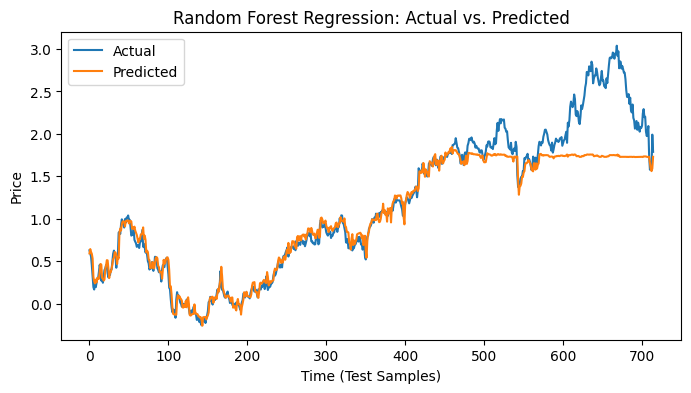

In [26]:
# Suppose X_test.index is a datetime index or just sequential if not
plt.figure(figsize=(8, 4))
plt.plot(y_test_scaled, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel("Time (Test Samples)")
plt.ylabel("Price")
plt.title("Random Forest Regression: Actual vs. Predicted")
plt.legend()
plt.show()

In [27]:
# PART 1
# XGB
model_xgbr = xgb.XGBRegressor() #(enable_categorical = True)
model_xgbr.fit(X_train_scaled, y_train_scaled)
predictions = model_xgbr.predict(X_test_scaled)
mse = mean_squared_error(y_test_scaled, predictions)
print("Model", model_xgbr)
print ("MSE: ", mse, '\n')
print ("Train Score: ", model_xgbr.score(X_train_scaled, y_train_scaled))
print ("Test Score: ", model_xgbr.score(X_test_scaled, y_test_scaled))

Model XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)
MSE:  0.09667194321870104 

Train Score:  0.9999550056031842
Test Score:  0.8649960160039327


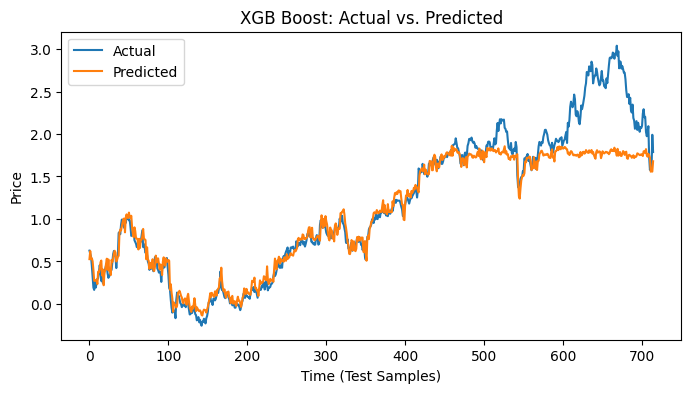

In [29]:
plt.figure(figsize=(8, 4))
plt.plot(y_test_scaled, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel("Time (Test Samples)")
plt.ylabel("Price")
plt.title("XGB Boost: Actual vs. Predicted")
plt.legend()
plt.show()

In [ ]:
# PART 1
# Lasso Regression
model_las = linear_model.Lasso(alpha=0.1)
model_las.fit(X_train_scaled, y_train_scaled)
predictions = model_las.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("Model: ", model_las)
print ("MSE: ", mse, '\n')
print ("Train Score: ", model_las.score(X_train_scaled, y_train_scaled))
print ("Test Score: ", model_las.score(X_test_scaled, y_test_scaled))

Model:  Lasso(alpha=0.1)
MSE:  246.2918470620671 

Train Score:  0.987838763777301
Test Score:  0.963664457116763


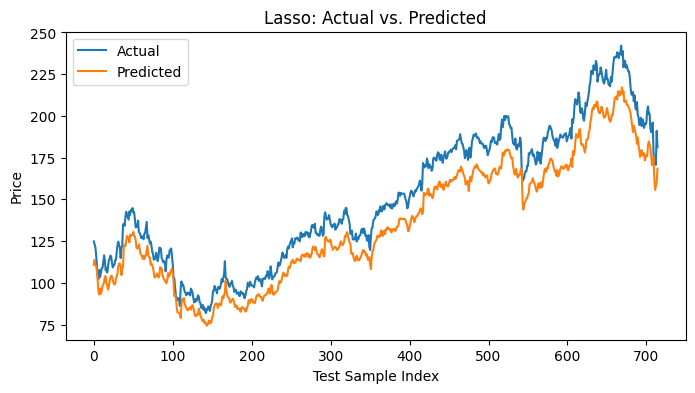

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose y_test are the actual values, and predictions are from RandomForestRegressor
x_axis = np.arange(len(y_test))  # 0, 1, 2, ..., number of test samples - 1

plt.figure(figsize=(8, 4))
plt.plot(x_axis, y_test.values, label='Actual')
plt.plot(x_axis, predictions, label='Predicted')
plt.xlabel("Test Sample Index")
plt.ylabel("Price")
plt.title("Lasso: Actual vs. Predicted")
plt.legend()
plt.show()

In [36]:
# PART 1
# Ridge Regression
model_rig = Ridge(alpha=0.1, positive = True)
model_rig.fit(X_train_scaled, y_train_scaled)
predictions = model_rig.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("Model: ", model_rig)
print ("MSE: ", mse, '\n')
print ("Train Score: ", model_rig.score(X_train_scaled, y_train_scaled))
print ("Test Score: ", model_rig.score(X_test_scaled, y_test_scaled))

Model:  Ridge(alpha=0.1, positive=True)
MSE:  11.453530835343848 

Train Score:  0.997918176712149
Test Score:  0.9936494353497899


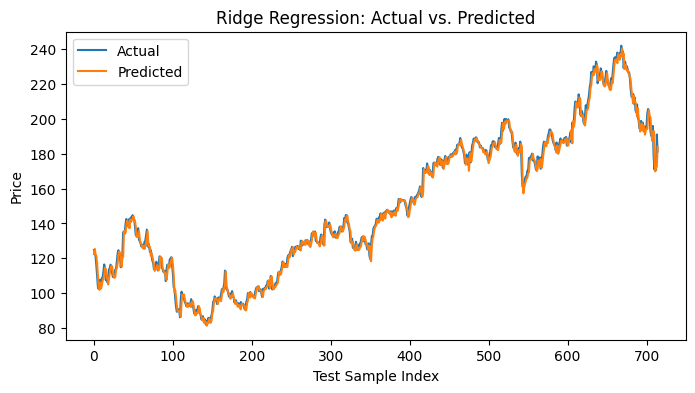

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose y_test are the actual values, and predictions are from RandomForestRegressor
x_axis = np.arange(len(y_test))  # 0, 1, 2, ..., number of test samples - 1

plt.figure(figsize=(8, 4))
plt.plot(x_axis, y_test.values, label='Actual')
plt.plot(x_axis, predictions, label='Predicted')
plt.xlabel("Test Sample Index")
plt.ylabel("Price")
plt.title("Ridge Regression: Actual vs. Predicted")
plt.legend()
plt.show()

In [20]:
# PART 1
# Logistic Regression
# normally a classifier
model_logreg = LogisticRegression()
model_logreg.fit(X_trainc, y_trainc)
predictions =model_logreg.predict(X_testc)
mse = mean_squared_error(y_testc, predictions)
print("Model: ", model_logreg)
print ("MSE: ", mse, '\n')
print ("Train Score: ", model_logreg.score(X_trainc, y_trainc))
print ("Test Score: ", model_logreg.score(X_testc, y_testc))

Model:  LogisticRegression()
MSE:  0.40559440559440557 

Train Score:  0.6212484993997599
Test Score:  0.5944055944055944


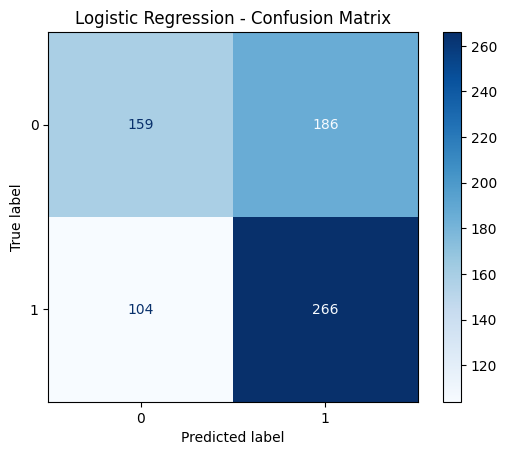

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# predictions are discrete class labels (0 or 1, for example)
cm = confusion_matrix(y_testc, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])  # or custom class labels
disp.plot(cmap=plt.cm.Blues)
plt.title("Logistic Regression - Confusion Matrix")
plt.show()


In [38]:
# PART 2
# prepare data for gap analysis
# group all days into 4 groups
# GapUp-IntraUp(ID=1), GapUp-IntraDn(2), GapDn-IntraDn(3), GapDn-IntraUp(4)

def categorize_gap_intra(row):
    if (row['Gap'] >= 0) & (row['Intraday'] >= 0):
        return 1
    elif (row['Gap'] >= 0) & (row['Intraday'] < 0):
        return 2
    elif (row['Gap'] < 0) & (row['Intraday'] < 0):
        return 3
    else:
        return 4

data['Gap_Intra'] = data.apply(categorize_gap_intra, axis=1)







In [39]:
# calculate returns by days(#)
data['1day_return']=(data['Close']/data['Close'].shift(1))-1
data['2day_return']=(data['Close']/data['Close'].shift(2))-1
data['3day_return']=(data['Close']/data['Close'].shift(3))-1
data['4day_return']=(data['Close']/data['Close'].shift(4))-1
data['5day_return']=(data['Close']/data['Close'].shift(5))-1
data['10day_return']=(data['Close']/data['Close'].shift(10))-1
data['20day_return']=(data['Close']/data['Close'].shift(20))-1

# group by return by days to see if classification is relevant - it is relevant
grouped_Gap_Intra = data.groupby('Gap_Intra')
grouped_Gap_Intra[['1day_return', '2day_return', '3day_return', '4day_return', '5day_return', '10day_return', '20day_return']].mean()


,1day_return,2day_return,3day_return,4day_return,5day_return,10day_return,20day_return
Gap_Intra,,,,,,,
1,0.019295,0.020493,0.021914,0.021824,0.022388,0.025322,0.037141
2,-0.004478,-0.002292,-0.002157,-0.000942,-0.000531,0.007269,0.014294
3,-0.019918,-0.018807,-0.016435,-0.015222,-0.013431,-0.010462,0.002278
4,0.003410,0.002382,0.002362,0.004107,0.005444,0.010304,0.016672


In [40]:
# add slopes so we can predict Gap_Intra
data['slope5_RSI']=data['RSI'].rolling(5).apply(lambda s: linregress(range(5), s.values)[0])
data['slope5_CCI']=data['CCI'].rolling(5).apply(lambda s: linregress(range(5), s.values)[0])
data['slope5_ATR']=data['ATR'].rolling(5).apply(lambda s: linregress(range(5), s.values)[0])
data['slope5_EMA10']=data['EMA10'].rolling(5).apply(lambda s: linregress(range(5), s.values)[0])
data['slope5_EMA50']=data['EMA50'].rolling(5).apply(lambda s: linregress(range(5), s.values)[0])
data['slope5_EMA200']=data['EMA200'].rolling(5).apply(lambda s: linregress(range(5), s.values)[0])
data['slope4_RSI']=data['RSI'].rolling(4).apply(lambda s: linregress(range(4), s.values)[0])
data['slope4_CCI']=data['CCI'].rolling(4).apply(lambda s: linregress(range(4), s.values)[0])
data['slope4_ATR']=data['ATR'].rolling(4).apply(lambda s: linregress(range(4), s.values)[0])
data['slope4_EMA10']=data['EMA10'].rolling(4).apply(lambda s: linregress(range(4), s.values)[0])
data['slope4_EMA50']=data['EMA50'].rolling(4).apply(lambda s: linregress(range(4), s.values)[0])
data['slope4_EMA200']=data['EMA200'].rolling(4).apply(lambda s: linregress(range(4), s.values)[0])
data['slope3_RSI']=data['RSI'].rolling(3).apply(lambda s: linregress(range(3), s.values)[0])
data['slope3_CCI']=data['CCI'].rolling(3).apply(lambda s: linregress(range(3), s.values)[0])
data['slope3_ATR']=data['ATR'].rolling(3).apply(lambda s: linregress(range(3), s.values)[0])
data['slope3_EMA10']=data['EMA10'].rolling(3).apply(lambda s: linregress(range(3), s.values)[0])
data['slope3_EMA50']=data['EMA50'].rolling(3).apply(lambda s: linregress(range(3), s.values)[0])
data['slope3_EMA200']=data['EMA200'].rolling(3).apply(lambda s: linregress(range(3), s.values)[0])
data['slope2_RSI']=data['RSI'].rolling(2).apply(lambda s: linregress(range(2), s.values)[0])
data['slope2_CCI']=data['CCI'].rolling(2).apply(lambda s: linregress(range(2), s.values)[0])
data['slope2_ATR']=data['ATR'].rolling(2).apply(lambda s: linregress(range(2), s.values)[0])
data['slope2_EMA10']=data['EMA10'].rolling(2).apply(lambda s: linregress(range(2), s.values)[0])
data['slope2_EMA50']=data['EMA50'].rolling(2).apply(lambda s: linregress(range(2), s.values)[0])
data['slope2_EMA200']=data['EMA200'].rolling(2).apply(lambda s: linregress(range(2), s.values)[0])

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2382 entries, 201 to 2582
Data columns (total 49 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   Date              2382 non-null   datetime64[ns, UTC]
 1   Open              2382 non-null   float64            
 2   High              2382 non-null   float64            
 3   Low               2382 non-null   float64            
 4   Close             2382 non-null   float64            
 5   Volume            2382 non-null   int64              
 6   RSI               2382 non-null   float64            
 7   CCI               2382 non-null   float64            
 8   ATR               2382 non-null   float64            
 9   EMA10             2382 non-null   float64            
 10  EMA50             2382 non-null   float64            
 11  EMA200            2382 non-null   float64            
 12  Gap               2382 non-null   float64            
 13  G

In [63]:
# clean data and split data
data_gap_intra = data.dropna()

Xg = data_gap_intra[['RSI', 'CCI', 'ATR', 'EMA10', 'EMA50', 'EMA200', 'slope5_RSI', 'slope5_CCI', 'slope5_ATR', 
    'slope5_EMA10', 'slope5_EMA50', 'slope5_EMA200','slope4_RSI', 'slope4_CCI', 'slope4_ATR', 
    'slope4_EMA10', 'slope4_EMA50', 'slope4_EMA200','slope3_RSI', 'slope3_CCI', 'slope3_ATR', 
    'slope3_EMA10', 'slope3_EMA50', 'slope3_EMA200', 'slope2_RSI', 'slope2_CCI', 'slope2_ATR', 
    'slope2_EMA10', 'slope2_EMA50', 'slope2_EMA200']]
yg = data_gap_intra['Gap_Intra']

train_index = int(0.7 * len(Xg))
Xg_train, Xg_test = Xg[:train_index], Xg[train_index:]
yg_train, yg_test = yg[:train_index], yg[train_index:]

# no scaling of categories
sc = MinMaxScaler(feature_range=(0,1))
Xg_train = sc.fit_transform(Xg_train)
Xg_test = sc.fit_transform(Xg_test)

In [64]:
model_knn = KNeighborsClassifier(n_neighbors=40, weights='uniform', algorithm='auto', leaf_size=30, p=1, metric='minkowski', metric_params=None, n_jobs=1)
model_knn.fit(Xg_train, yg_train)

yg_pred_train = model_knn.predict(Xg_train)
yg_pred_test = model_knn.predict(Xg_test)
#print("Model: ", model_knn)
#print ("MSE: ", mse, '\n')
print ("Train Score: ", model_knn.score(Xg_train, yg_train))
print ("Test Score: ", model_knn.score(Xg_test, yg_test))

Train Score:  0.5093768905021173
Test Score:  0.4090267983074753


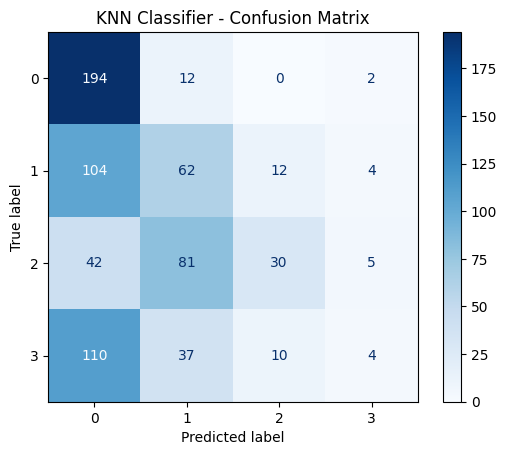

In [72]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# yg_test are the true labels; yg_pred_test are your model’s predictions
cm = confusion_matrix(yg_test, yg_pred_test)

cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot(cmap=plt.cm.Blues)
plt.title("KNN Classifier - Confusion Matrix")
plt.show()

In [56]:
# PART 3
# Prepare Data - use close
ticker_lstm = 'AMZN'
data_lstm = yf.download(tickers=ticker_lstm, start=start, end=end)
data_lstm = ticker.history(start=start, end=end)
data_lstm = data_lstm[['Close']]
# scale the data (between 0 and 1 - required for LSTM)
sc = MinMaxScaler(feature_range=(0,1))
sc_data = sc.fit_transform(data_lstm)

# Split  data
# split data  -- sequential data must be split by index
train_index_lstm = int(0.7 * len(sc_data))
train_data = sc_data[0:train_index_lstm, :]

X_trainl = []
y_trainl = []

# Use 60 days to predict price
for i in range(60, len(train_data)):
    X_trainl.append(train_data[i-60:i, 0])  
    y_trainl.append(train_data[i, 0]) # add predicted value to list     

# recast list as array
X_trainl, y_trainl = np.array(X_trainl), np.array(y_trainl)

# Reshape x_train to the format [samples, time steps, features] required for LSTM
X_trainl = np.reshape(X_trainl, (X_trainl.shape[0], X_trainl.shape[1], 1))
# # Prepare Test Data
test_data = sc_data[train_index_lstm - 60:, :]  # 60 to allow previous 60 steps

X_test1 = []
y_test1 = []

for i in range(60, len(test_data)):
    X_test1.append(test_data[i-60:i, 0])
    y_test1.append(test_data[i, 0])

X_test1, y_test1 = np.array(X_test1), np.array(y_test1)
X_test1 = np.reshape(X_test1, (X_test1.shape[0], X_test1.shape[1], 1))

[*********************100%***********************]  1 of 1 completed


In [57]:
# PART 3
# build model
model_lstm = Sequential()

model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_trainl.shape[1], 1))) # layer 1
model_lstm.add(Dropout(0.2))  # prevent overfitting

model_lstm.add(LSTM(units=50, return_sequences=False)) # layer 2
model_lstm.add(Dropout(0.2))  # prevent overfitting
model_lstm.add(Dense(units=25))  # Layer 3 (dense)
model_lstm.add(Dense(units=1)) # output layer (one price)
model_lstm.compile(optimizer='adam', loss='mean_squared_error')  # optimizer and lost function

# fit model
model_lstm.fit(X_trainl, y_trainl, batch_size=1, epochs=1)

1748/1748 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0043


In [58]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict on training data
train_predict = model_lstm.predict(X_trainl)
# Predict on test/validation data (assuming you have X_test1 and y_test1)
test_predict = model_lstm.predict(X_test1)

# Inverse transform for scaled y
train_predict = sc.inverse_transform(train_predict)
y_train_true = sc.inverse_transform(y_trainl.reshape(-1, 1))

test_predict = sc.inverse_transform(test_predict)
y_test_true = sc.inverse_transform(y_test1.reshape(-1, 1))

# Calculate MSE
train_mse = mean_squared_error(y_train_true, train_predict)
test_mse = mean_squared_error(y_test_true, test_predict)

# Calculate R² Score
train_r2 = r2_score(y_train_true, train_predict)
test_r2 = r2_score(y_test_true, test_predict)

print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Train R² Score: {train_r2}")
print(f"Test R² Score: {test_r2}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Train MSE: 52.14281480169745
Test MSE: 84.0654254610672
Train R² Score: 0.979341123842399
Test R² Score: 0.9477568944997677


In [59]:
# PART 3
price_history = -90
back_days = sc_data[price_history:]  # go back 90 days
X_future = back_days.reshape((1, back_days.shape[0], 1)) # reshape data

In [60]:
# PART 3: Generate Forecast
forecast_days = 60
predicted_prices = [] # need empty list
for _ in range(forecast_days):  
    pred = model_lstm.predict(X_future) # make predictions
    predicted_prices.append(pred[0, 0])  # Add prediction to list
    
    # Update x_future with the new prediction by removing the first value and adding the new prediction
    X_future = np.append(X_future[:, 1:, :], [[pred[0]]], axis=1)

predicted_prices = sc.inverse_transform(np.array(predicted_prices).reshape(-1, 1)) # unscaled data
type(predicted_prices)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━

numpy.ndarray

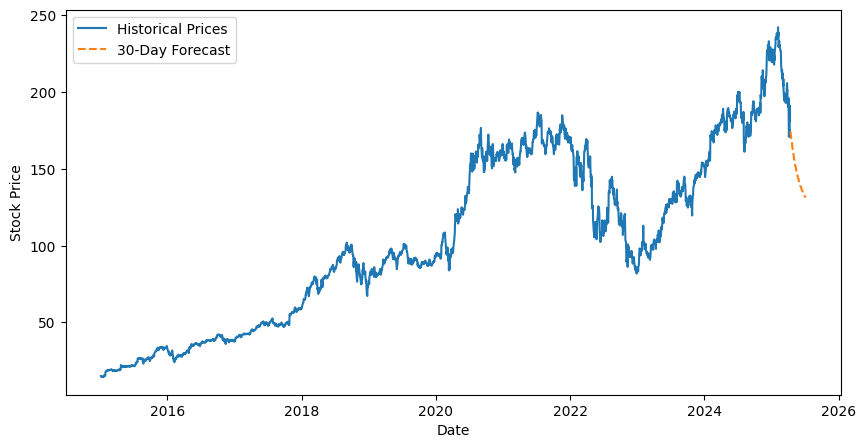

In [61]:

forecast_dates = pd.date_range(start=data_lstm.index[-1] + pd.Timedelta(days=1), periods=forecast_days, freq='B')
forecast = pd.DataFrame(predicted_prices, index=forecast_dates, columns=['Prediction'])

plt.figure(figsize=(10, 5))
plt.plot(data_lstm['Close'], label='Historical Prices')
plt.plot(forecast, label='30-Day Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
